In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import matplotlib.pyplot as plt

In [6]:
import json
import pandas as pd
with open('ejecuciones/CrossoverExplotacion_Reflection_Gemini2/heuristics_data.json', 'r') as file:
    heuristics_data = json.load(file)
with open('ejecuciones/CrossoverExplotacion_Reflection_Gemini2/final_information.json', 'r') as file:
    final_information = json.load(file)

In [8]:
best = pd.read_csv("problems/jssp/greedy_solution.csv")

In [ ]:
with open('ejecuciones/CrossoverExplotacion_Reflection_Gemini2/heuristics_data.json', 'r') as file:
    heuristics_data = json.load(file)
best = pd.read_csv("problems/jssp/greedy_solution.csv")
epsilon = 0.1

scores = {}

max_values_per_instance = {}

for heuristic in heuristics_data:
    if heuristic['evaluation'] not in ['Code Error', 'Infeasible']:
        for instance, evaluation in heuristic['evaluation'].items():
            if instance not in max_values_per_instance:
                max_values_per_instance[instance] = {'Makespan': float('-inf'), 'Balance': float('-inf'), 'Separation': float('-inf')}
            for of_name, of_value in evaluation.items():
                max_values_per_instance[instance][of_name] = max(max_values_per_instance[instance][of_name], of_value)

for heuristic in heuristics_data:
    if heuristic['evaluation'] not in ['Code Error', 'Infeasible']:
        scores[heuristic['id']] = {'id': heuristic['id'], 'Makespan': 0, 'Balance': 0, 'Separation': 0, 'Generation': heuristic['generation'], 'Mean': 0}
        for instance_name, evaluation in heuristic['evaluation'].items():
            for of_name, of_value in evaluation.items():
                    min_value = best.loc[best['instance'] == instance_name, of_name].iloc[0]
                    scores[heuristic['id']][of_name] += (1-float(( of_value - min_value)/ (max_values_per_instance[instance_name][of_name] - min_value)))
        scores[heuristic['id']]['Makespan'] /= len(heuristic['evaluation'])
        scores[heuristic['id']]['Balance'] /= len(heuristic['evaluation'])
        scores[heuristic['id']]['Separation'] /= len(heuristic['evaluation'])
        scores[heuristic['id']]['Mean'] = (scores[heuristic['id']]['Makespan'] + scores[heuristic['id']]['Balance'] + scores[heuristic['id']]['Separation']) / 3

In [102]:
import numpy as np

def get_pareto_front(solutions):
    pareto_front = []
    
    for _, candidate in solutions.items():
        dominated = False
        for _, other in solutions.items():
            if all(other[obj] >= candidate[obj] for obj in candidate) and any(other[obj] > candidate[obj] for obj in candidate):
                dominated = True
                break
        if not dominated:
            pareto_front.append(candidate)
    
    return pareto_front

In [103]:
pareto_front = get_pareto_front(scores)

In [104]:
len(pareto_front)

23

In [97]:
pareto_generations = [0] * max(h['generation'] for h in heuristics_data)
for h in pareto_front:
    pareto_generations[h['Generation'] - 1] += 1

In [98]:
pareto_generations

[0, 1, 2, 0, 2, 3, 2, 4, 1, 2, 3, 5, 3, 3, 6, 7, 3, 8, 9, 12]

In [99]:
max_mean = 0
for h in scores.values():
    if h['Mean'] > max_mean:
        max_heuristic = h

In [100]:
h

{'id': 440,
 'Makespan': -0.09499035794113872,
 'Balance': -0.12563969543043804,
 'Separation': -14969.656297073701,
 'Generation': 20,
 'Mean': -4989.958975709024}

In [47]:
len(pareto_front)

62

In [43]:
len(pareto_front)

6

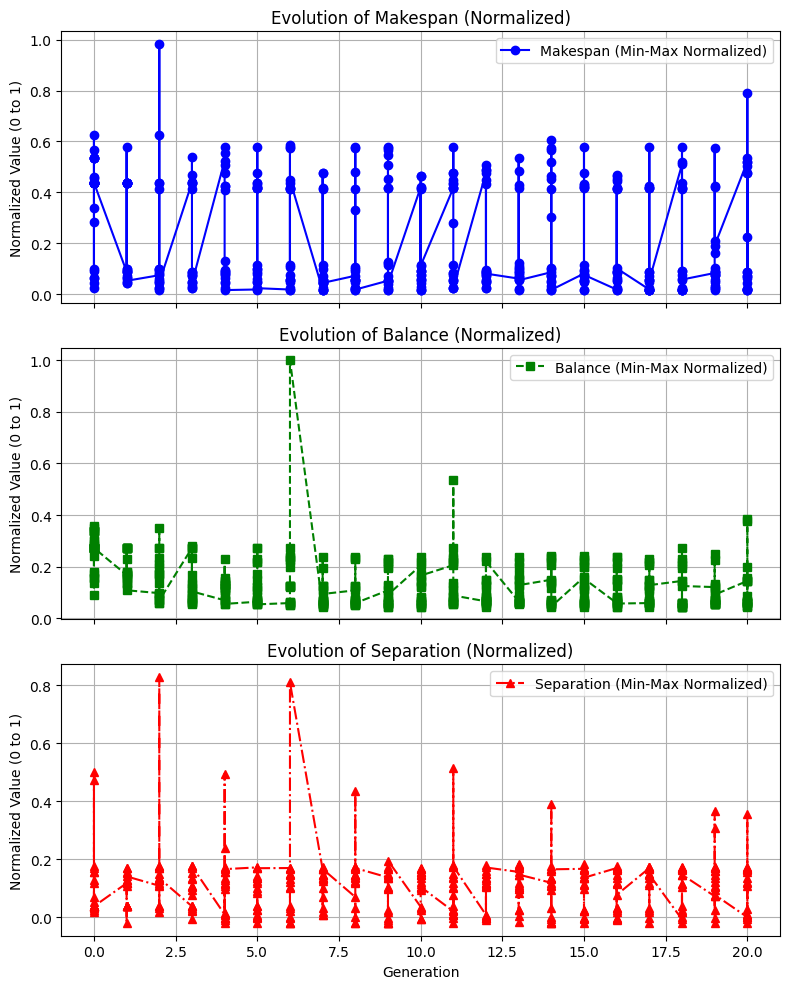

In [27]:
ids = list(scores.keys())
makespan = [scores[g]['Makespan'] for g in ids]
balance = [scores[g]['Balance'] for g in ids]
separation = [scores[g]['Separation'] for g in ids]
generations = [scores[g]['Generation'] for g in ids]

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axes[0].plot(generations, makespan, marker='o', linestyle='-', color='b', label="Makespan (Min-Max Normalized)")
axes[1].plot(generations, balance, marker='s', linestyle='--', color='g', label="Balance (Min-Max Normalized)")
axes[2].plot(generations, separation, marker='^', linestyle='-.', color='r', label="Separation (Min-Max Normalized)")

axes[0].set_title("Evolution of Makespan (Normalized)")
axes[1].set_title("Evolution of Balance (Normalized)")
axes[2].set_title("Evolution of Separation (Normalized)")

for ax in axes:
    ax.set_ylabel("Normalized Value (0 to 1)")
    ax.legend()
    ax.grid(True)

axes[2].set_xlabel("Generation")

plt.tight_layout()
plt.show()